# Dataset Preview

### Notebook utilizado para pré visualização dos dados de exame

### Pacotes Utilizados:

In [ ]:
%pip install pyEDFlib
%pip install mne

In [31]:
#Definindo padrões de plot
plot_kwargs = {
    'scalings': dict(eeg=20e-5),
    'show_scrollbars': False,
}

#Definindo esse canais, pois são os presentes em todos os pacientes
selected_channels = [
    'P8-O2',
    'CZ-PZ',
    'T8-P8',
    'T7-P7',
    'FZ-CZ',
    'C3-P3',
    'P4-O2',
    'C4-P4',
    'FP1-F7',
    'F3-C3',
    'F4-C4',
    'P7-O1',
    'FP2-F8',
    'F7-T7',
    'FP2-F4',
    'FP1-F3',
    'P3-O1',
    'F8-T8'
]

In [ ]:
import database.databaseutils as db
import reader.edfreader as edfreader
import reader.mnereader as mnereader
import model.summarymodel as summary
import model.summarymodelconverter as converter

db.connect()

st = db.summary_by_name('chb01_03.edf')
summary_model = converter.model_from_tuple(st)
seizures = [[int(x) for x in summary_model.start_seizure], [int(x) for x in summary_model.end_seizure]]

data, freq = edfreader.raw_data(summary_model, selected_channels)
mne_data = mnereader.mne_object(data, freq, events = seizures if summary_model.nr_seizures > 0 else None)

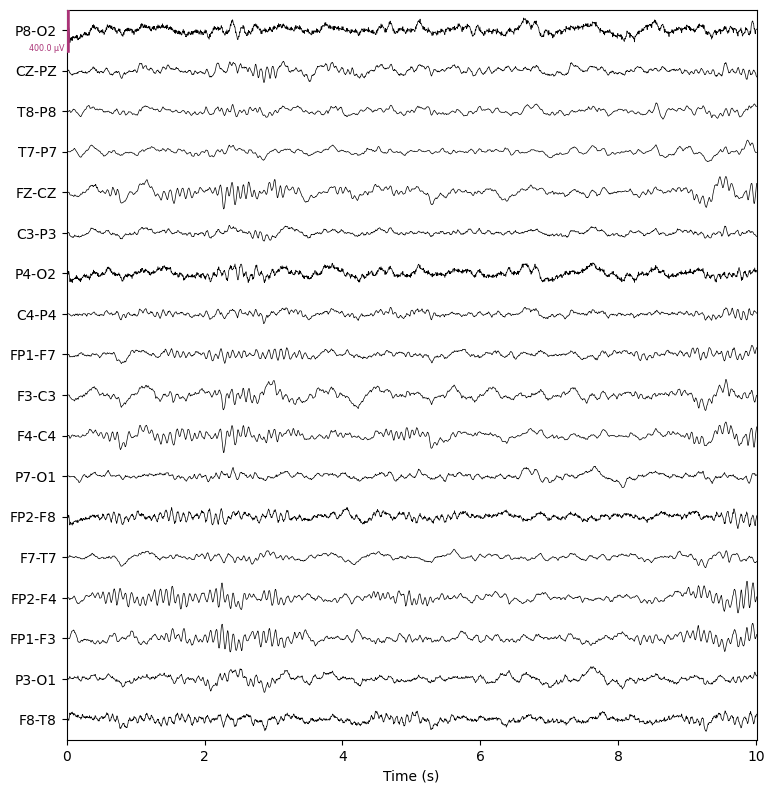

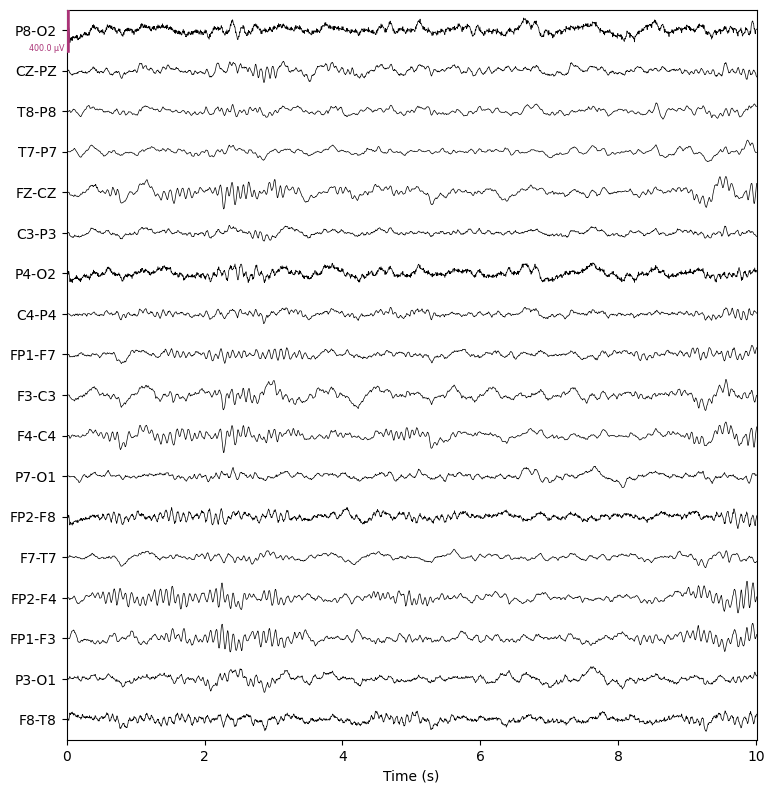

In [33]:
mne_data.plot(start = 0, **plot_kwargs)

In [34]:
import re
import matplotlib.pyplot as plt

replace_dict = {}
drop_list = []
for channel_name in mne_data.info['ch_names']:
    name_change = re.findall('\w+',channel_name)[0].title()
    if name_change in list(replace_dict.values()):
        drop_list.append(channel_name)
    else:
        replace_dict[channel_name] = name_change

mne_data.drop_channels(drop_list)
mne_data.rename_channels(replace_dict)
mne_data.set_montage('standard_1020')

<RawArray | 16 x 921600 (3600.0 s), ~112.5 MB, data loaded>

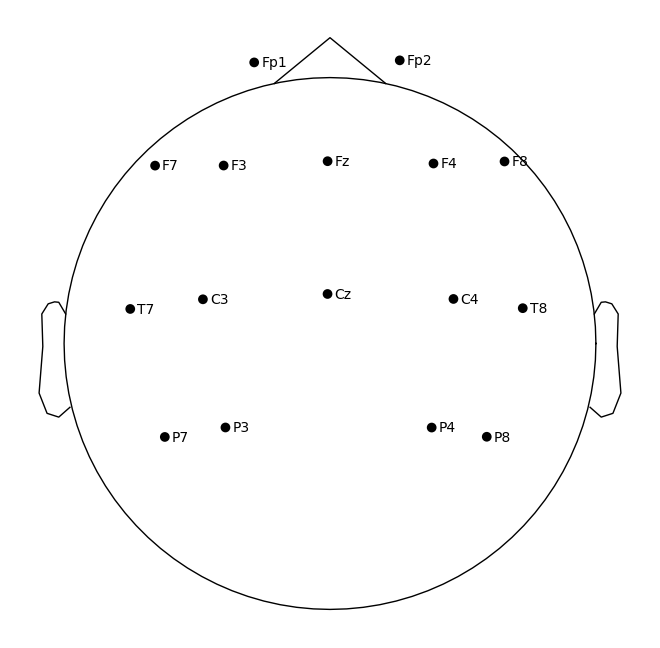

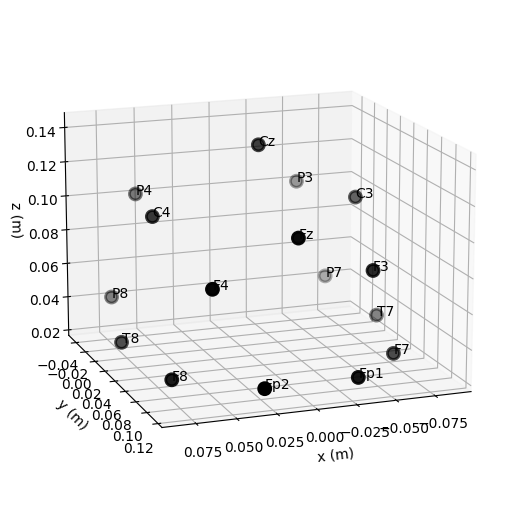

In [37]:
mne_data.plot_sensors(kind='topomap', show_names=True, to_sphere=True)
fig = mne_data.plot_sensors(kind='3d', show_names=True, show=False)
fig = fig.gca().view_init(azim=70, elev=15)
plt.show()

In [ ]:
from scipy import signal
def ave_freq(data):
    win = 4 * freq
    freqs, psd = signal.welch(data, freq, nperseg=win, scaling='spectrum')
    #print(freqs[4:160])
    return psd[:,4:160].mean(1)

inter_array = mne_data[:, 50*freq:80*freq][0]
ictal_array = mne_data[:, (seiz_start_time*freq):(seiz_start_time*freq)+30*freq][0]
topo_df = pd.DataFrame([ave_freq(inter_array),ave_freq(ictal_array)], index=['inter', 'ictal'])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs = axs.flatten()
for i, data_class in enumerate(topo_df.T):
    topo, cn = mne.viz.plot_topomap(topo_df.loc[data_class],
                                    mne_data.info,
                                    show=False,
                                    sensors=False,
                                    names=mne_data.info['ch_names'], 
                                    show_names=True,
                                    axes = axs[i],
                                    vmin = topo_df.values.min(),
                                    vmax = topo_df.values.max())
    axs[i].set_title(data_class)
    
fig.show()